This prediction demonstration is based on this 
[demo notebook](https://github.com/knowledgedefinednetworking/demo-routenet/blob/master/demo_notebooks/demo.ipynb)
Copyright 2019 José Suárez-Varela, Sergi Carol-Bosch, Krzysztof Rusek, Paul Almasan, Marta Arias, Pere Barlet-Ros, Albert Cabellos-Aparicio.
Universitat Politècnica de Catalunya, AGH University of Science and Technology
Licensed under the MIT License (the "License"), see end.


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import os
import random
from routenet.model.routenet_model import RouteNetModel
from routenet.data_utils.omnet_tfrecord_utils import read_dataset
%load_ext autoreload
%autoreload 2

W0929 17:50:14.273071 4356482496 lazy_loader.py:50] 
The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



# Delay Prediction with RouteNet

The code below demonstrates how to use the RouteNetModel to predict the per-source/destination 
delay. First we provide an example of the mechanics by comparing a test sample of training data against a trained model, then we try the same trained model against a previously unseen network.

This code uses the sample data sets from the OMNet++ simulations, the structure of which
is explained in [OMNet++ Data Files and Formats](../OMNet_Data_Files_and_Formats.md).

## Training Network Data Sets

TODO validate the 480K figure.

The trained model, from which the previously trained variables are transferred, is based on 480K 
training samples, including 240K samples from the 
[14-node NSF network topology](http://knowledgedefinednetworking.org/data/datasets_v0/nsfnet.tar.gz) 

![14 Node NSF OMNet++ Topology](assets/nsfnet_topology.png)

and 240K samples from the 
[50-node synthetically-generated topology](http://knowledgedefinednetworking.org/data/datasets_v0/synth50.tar.gz).

![50-node synthetically-generated topology](assets/synth50_topology.png)
 
The training is executed with the [train_multiple.py](../bin/train_multiple.py) script, with 100K training steps. During training, [model checkpoints](https://www.tensorflow.org/guide/checkpoint) were saved, from which we (re)load variables below, so as to be able to reuse the trained model. Training the model on an iMac late 2012 with 3.4GHz i7 and 32GB RAM takes n days. TODO

## Evaluation Network Data Sets

# Code

The code below is presented in two parts:

 - Utility functions to sample from the data sets, instantiate a model and run predictions.
 - Analysis functions to provide visual and numerical analysis.
 
The steps below first evaluate the trained model against the training data, which is a best case analysis, then against previously unseen networks.


## Utility Functions

The utility functions below provide the following capabilities:

 - Select a random sample from a simulation dataset.
 - Create a RoutNetModel instance and initialise its readout layer from the sample.
 - Create a session with a graph based on the model readout, and restore into the session variables from a model checkpoint, i.e. transfer the weights from the previously trained model.
 

The data sets are in a directory identified by the `OMNET_DATA_DIR` environment variable. See the 
[get_omnet_data.sh](../bin/get_omnet_data.sh) bash script if you do not already have that data in
your local file system.

In [2]:
def get_sample(network_name):
    random.seed(13)
    # Path to data sets
    omnet_data_dir = os.getenv('OMNET_DATA_DIR')
    # TODO should this not be an evaluation data set?
    train_data_path = omnet_data_dir+'/' + network_name + '/tfrecords/train/'
    train_data_filename = random.choice(os.listdir(train_data_path))
    sample_file = train_data_path + train_data_filename
    # print(sample_file.split('/')[-1])
    return sample_file

In [3]:
def get_model_readout(test_sample_file):
    graph = tf.Graph()
    with graph.as_default():
        model = RouteNetModel()
        model.build()
    
        data_set = read_dataset(test_sample_file)
        data_set_itrtr = data_set.make_initializable_iterator()
        # The `label` here is the delay value associated with the features. The features are selected in
        # the transformation_func(...) from the train module.
        features, label = data_set_itrtr.get_next()
    
        with tf.name_scope('predict'):
            # The lamba construct below invokes RouteNetModel.call(features, training=True).
            # The return value from the call(...) function is the readout Sequential() model, with
            # training set to `True`.
            readout = tf.map_fn(lambda x: model(x, training=True), features, dtype=tf.float32)
    
        # Having called this on one set of features, we have an initialised readout.
        # We squeeze the tensor to ... TODO
        readout = tf.squeeze(readout)
        # This is the reverse of the normalisation applied in the parse function in 
        # omet_tfrecord_utils.
        # TODO the rationale for the normalisation has to be explained.
        readout = 0.54*readout + 0.37

        return graph, readout, data_set_itrtr, label

In [4]:
def run_predictions(graph, readout, data_itrtr, true_value):

    with tf.compat.v1.Session(graph=graph) as sess:
        sess.run(tf.compat.v1.local_variables_initializer())
        sess.run(tf.compat.v1.global_variables_initializer())
        saver = tf.compat.v1.train.Saver()
        # Load the weights from the checkpoint
        saver.restore(sess, '../model_checkpoints-imac/model.ckpt-8151')
    
        # We are going to take a median of a number of predictions
        predictions = []
        # We run the model 50 times to predict delays based for the network represented by the sample
        # data set.
        for _ in range(50):
            sess.run(data_itrtr.initializer)
            # The `true_delay` value here is the original delay value from the sample data set, 
            # against which we compare the median value of the predicted delay below.
            # TODO check why true_value has to be passed in
            # Note that we need to pass back the median of the `pred_delay` and the true_delay
            # just so that we have two tensors of the same shape for graphing purposes.
            pred_delay, true_delay = sess.run([readout, true_value])
            predictions.append(pred_delay)
    
        median_prediction = np.median(predictions, axis=0)

        return median_prediction, predictions, true_delay

In [5]:
# First get a sample file from the nsfnetbw network.
sample_file = get_sample('nsfnetbw')

# Then create a RoutNetModel instance and initialise its readout layer with a sample from the `sample_file`.
pred_graph, pred_readout, itrtr, label = get_model_readout(sample_file)

# We now have a readout Sequential model initialised with the sample data, and so the network that
# data represents, with training set to True, within the `pred_graph` Graph.  

# We can now create a session with that graph, and restore into the session the variables from a
# model checkpoint, i.e. we can transfer the weights from the previously trained model.
final_prediction, predicted_delays, true_delay = run_predictions(pred_graph, pred_readout, itrtr, label)

W0929 17:50:14.898512 4356482496 deprecation.py:506] From /usr/local/lib/python3.7/site-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W0929 17:50:15.193429 4356482496 deprecation.py:323] From <ipython-input-3-e0afec24a106>:8: DatasetV1.make_initializable_iterator (from tensorflow.python.data.ops.dataset_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use `for ... in dataset:` to iterate over a dataset. If using `tf.estimator`, return the `Dataset` object directly from your input function. As a last resort, you can use `tf.compat.v1.data.make_initializable_iterator(dataset)`.
******** in call ******************
W0929 17:50:16.157313 4356482496 deprecation.py:323] From /usr/local/lib/python3.7/si

At this point we have the per-source/destination delay values predicted by RouteNet. 

Now we can compare the predictions from RouteNet with the real values `true_delay` produced by OMNet++. 

Since there is a large number of delay predictions in a single sample, we randomly sample some of the results and plot them.

Note that these plots are for sample data from the same network mode, `nsfnetbw`, that was used for training. We expect the results to very good under these circumstances. We are illustrating this as a reference point for how
good the results can be when testing against the training data.

In [6]:
num_paths = 40 # Set how many paths you want to visualize
ids = random.sample(range(0, len(final_prediction)), num_paths)
ids.sort()

sample_prediction = []
sample_label = []

for i in ids:
    sample_prediction.append(final_prediction[i])
    sample_label.append(true_delay[0][i])

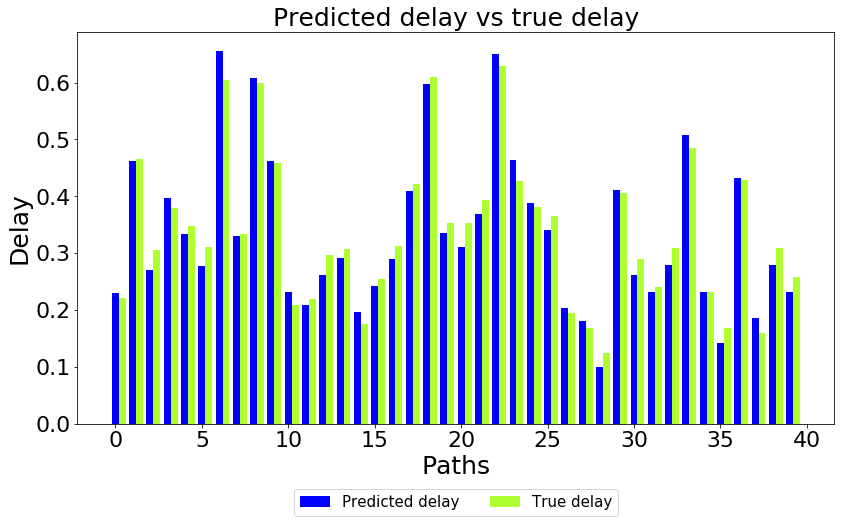

In [7]:
# create plot
fig, ax = plt.subplots()
index = np.arange(num_paths)
bar_width = 0.40

rects1 = plt.bar(index, sample_prediction, bar_width,
color='b',
label='Predicted delay')

rects2 = plt.bar(index + bar_width, sample_label, bar_width,
color='greenyellow',
label='True delay')

for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(22)
for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(22)

plt.xlabel('Paths',fontsize=25)
plt.ylabel('Delay',fontsize=25)
plt.title('Predicted delay vs true delay',fontsize=25)
plt.legend(loc='center',fontsize=15,bbox_to_anchor=(0.5, -0.20),fancybox=True,ncol=2)
plt.tight_layout()

fig = plt.gcf()
fig.set_size_inches(14, 8.5)

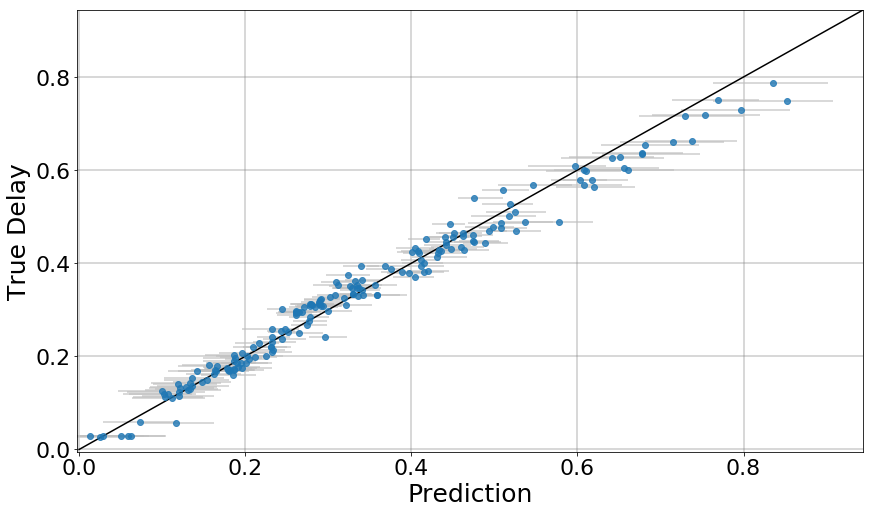

In [8]:
ax = plt.subplot()

xerr = [final_prediction - np.percentile(predicted_delays, q=5, axis=0),
        np.percentile(predicted_delays, q=95, axis=0) - final_prediction]

ax.errorbar(x=final_prediction, y=true_delay[0], fmt='o', xerr=xerr, alpha=0.8, ecolor='silver')

m = max(true_delay[0])
ax.plot([0, 1.3 * m], [0, 1.3 * m], 'k')
ax.grid(color='gray', linestyle='-', linewidth=2, alpha=0.3)
ax.set_xlabel('Prediction', fontsize=25)
ax.set_ylabel('True Delay', fontsize=25)
for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(22)
for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(22)
ax.set_xlim(left=-0.002, right=1.2 * m)
ax.set_ylim(bottom=-0.005, top=1.2 * m)
fig = plt.gcf()
plt.tight_layout()
fig.set_size_inches(14, 8.5)

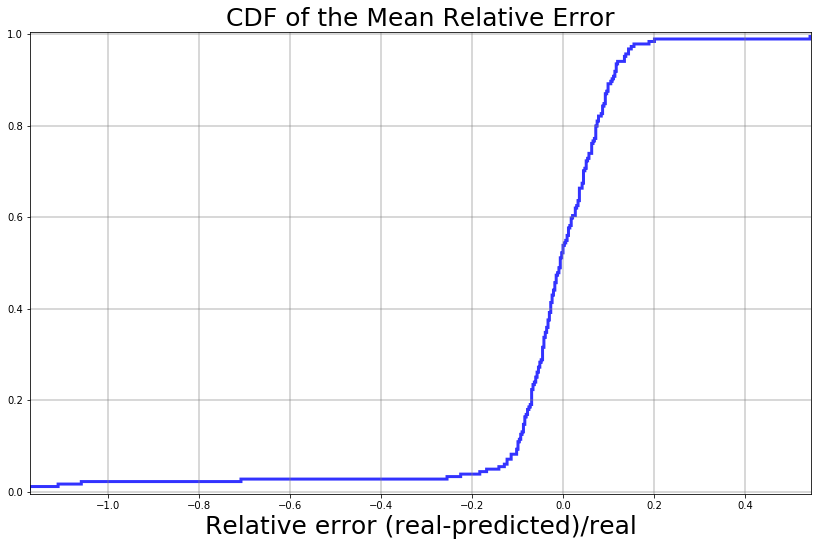

In [9]:
def frange(x, y, jump):
  while x < y:
    yield x
    x += jump

mre = (true_delay-final_prediction)/true_delay
mre = np.sort(mre)

mre = np.insert(mre, 0, -15.0)
mre = np.append(mre, 15.0)

plt.hist(mre, cumulative=True, 
         histtype='step', 
         bins=10000, 
         alpha=0.8, 
         color='blue', 
         density=True, 
         linewidth=3)
plt.ylim((-0.005, 1.005))
plt.xlim((mre[1], mre[-2]))
plt.xlabel("Relative error (real-predicted)/real", fontsize=25)
plt.rc('xtick',labelsize=22)
plt.rc('ytick',labelsize=22)
plt.grid(color='gray', linestyle='-', linewidth=2, alpha=0.3)
plt.title('CDF of the Mean Relative Error',fontsize=25)
fig = plt.gcf()
fig.set_size_inches(14, 8.5)

# References

Rusek, K., Suárez-Varela, J., Mestres, A., Barlet-Ros, P., & Cabellos-Aparicio, A. (2019, April). 
Unveiling the potential of Graph Neural Networks for network modeling and optimization in SDN. 
In Proceedings of the 2019 ACM Symposium on SDN Research (pp. 140-151). ACM.

In [10]:
#@title Licensed under the MIT License (the "License"); { display-mode:"form" }
# MIT License

# Copyright (c) 2019 Paul Almasan, José Suárez-Varela, Krzysztzof Rusek

# Permission is hereby granted, free of charge, to any person obtaining a copy
# of this software and associated documentation files (the "Software"), to deal
# in the Software without restriction, including without limitation the rights
# to use, copy, modify, merge, publish, distribute, sublicense, and/or sell
# copies of the Software, and to permit persons to whom the Software is
# furnished to do so, subject to the following conditions:

# The above copyright notice and this permission notice shall be included in all
# copies or substantial portions of the Software.

# THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
# IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
# FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE
# AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
# LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM,
# OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE
# SOFTWARE.

